<a href="https://colab.research.google.com/github/sherxon/kaggle/blob/main/disaster_twiiter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from keras.models import Model
from keras.layers import Dense, Input, Embedding, Activation, Flatten, LSTM, Dropout, Bidirectional
import keras.callbacks as callbacks
from sklearn import feature_extraction
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras.regularizers as regularizers
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
train_df= pd.read_csv('/content/drive/My Drive/kaggle/disaster_twitter/train.csv')
test_df = pd.read_csv('/content/drive/My Drive/kaggle/disaster_twitter/test.csv')

In [ ]:
#count_vectorizer = feature_extraction.text.CountVectorizer()

In [ ]:
t= Tokenizer()

In [ ]:
t.fit_on_texts(list(train_df['text'])+ list(test_df['text']))

In [ ]:
train_encoded = t.texts_to_sequences(train_df['text'])
test_encoded = t.texts_to_sequences(test_df['text'])

In [ ]:
max_length=0;
for tweet in train_encoded:
  if(max_length < len(tweet)):
    max_length=len(tweet)
print('max_length', max_length)

max_length 33


In [ ]:
padded_tweets=pad_sequences(train_encoded, maxlen=max_length, padding='post', value=0.0)
padded_test = pad_sequences(test_encoded, maxlen=max_length, padding='post', value=0.0)
print('train_padded', padded_tweets.shape)
print('test_padded', padded_test.shape)

train_padded (7613, 33)
test_padded (3263, 33)


In [ ]:
valid_words = t.word_index.keys()

In [ ]:
embeddings_index = dict()
f = open('glove.6B.50d.txt')
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  if word in valid_words:
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 14994 word vectors.


In [ ]:
vocab_size = len(t.word_index)+1
embedding_matrix = np.zeros((vocab_size, 50))
for word, i in t.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(29320, 50)

In [ ]:
#train_vectors = count_vectorizer.fit_transform(train_df['text'])
#test_vectors = count_vectorizer.transform(test_df['text'])
#print(train_vectors.shape)
#print(test_vectors.shape)

In [ ]:
Y=train_df['target'].to_numpy()
print(Y.shape)

(7613,)


In [ ]:
tweets_count=padded_tweets.shape[0]
print('vocab_size', vocab_size)
print('shape of train_input', padded_tweets.shape)
print('input tweet count', tweets_count)

vocab_size 29320
shape of train_input (7613, 33)
input tweet count 7613


In [ ]:
weight_decay=0.001

input = Input(shape=(max_length,))
embeddings=Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=max_length, trainable=False)(input)
X=Bidirectional(LSTM(128, return_sequences=True))(embeddings)
X=Dropout(0.4)(X)
X=Bidirectional(LSTM(128, return_sequences=False))(X)
X=Dropout(0.4)(X)
X=Dense(64, 'relu', kernel_regularizer=regularizers.l2(weight_decay))(X)
X=Dense(8, 'relu',  kernel_regularizer=regularizers.l2(weight_decay))(X)
X=Dense(1, activation='sigmoid')(X)
model = Model(input, X);
model.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 33)]              0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 33, 50)            1466000   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 33, 256)           183296    
_________________________________________________________________
dropout_10 (Dropout)         (None, 33, 256)           0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)              

In [ ]:
model.compile('Adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
def get_callbacks():
    """
    This function should create and return a tuple (early_stopping, learning_rate_reduction) callbacks.
    The callbacks should be instantiated according to the above requirements.
    """
    stop=callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')
    lr=callbacks.ReduceLROnPlateau(factor=0.2, patience=5)
    return stop, lr

early_stopping, learning_rate_reduction = get_callbacks()


In [ ]:
history = model.fit(padded_tweets, Y,  epochs = 20, batch_size = 64, validation_split=0.15,  callbacks=[early_stopping, learning_rate_reduction])

Epoch 1/20
102/102 [==============================] - 34s 334ms/step - loss: 0.5831 - accuracy: 0.7680 - val_loss: 0.5454 - val_accuracy: 0.7680
Epoch 2/20
102/102 [==============================] - 33s 319ms/step - loss: 0.5016 - accuracy: 0.8048 - val_loss: 0.5112 - val_accuracy: 0.7907
Epoch 3/20
102/102 [==============================] - 34s 332ms/step - loss: 0.4680 - accuracy: 0.8105 - val_loss: 0.4867 - val_accuracy: 0.7855
Epoch 4/20
102/102 [==============================] - 32s 318ms/step - loss: 0.4479 - accuracy: 0.8166 - val_loss: 0.4787 - val_accuracy: 0.7855
Epoch 5/20
102/102 [==============================] - 34s 330ms/step - loss: 0.4287 - accuracy: 0.8231 - val_loss: 0.4782 - val_accuracy: 0.7846
Epoch 6/20
102/102 [==============================] - 35s 339ms/step - loss: 0.4139 - accuracy: 0.8312 - val_loss: 0.4735 - val_accuracy: 0.7741
Epoch 7/20
102/102 [==============================] - 33s 326ms/step - loss: 0.3993 - accuracy: 0.8402 - val_loss: 0.4881 - val_ac

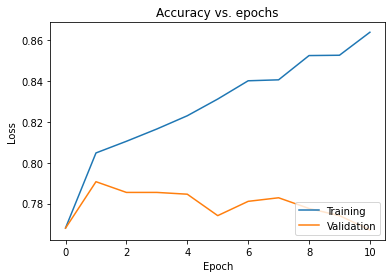

In [ ]:
try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except KeyError:
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

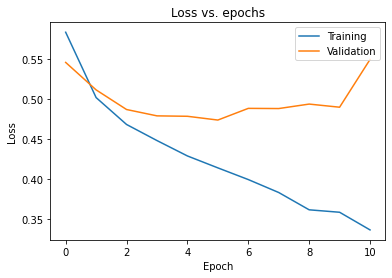

In [ ]:
#Run this cell to plot the epoch vs loss graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

In [ ]:
prediction = model.predict(padded_test)

In [ ]:
sample_suggestion=pd.read_csv('/content/drive/My Drive/kaggle/disaster_twitter/sample_submission.csv')

In [ ]:
prediction=np.rint(prediction).astype(int)

In [ ]:
sample_suggestion['target']=prediction
sample_suggestion.head()

,id,target
0,0,1
1,2,1
2,3,0
3,9,1
4,11,1


In [ ]:
sample_suggestion.to_csv('/content/drive/My Drive/kaggle/disaster_twitter/prediction5.csv', index=False)